In [2]:
import subprocess
import os
import math
from functions.basefunctions import *
from collections import defaultdict
import numpy as np
import time 

kbT_RNA = 0.6163207755

In [6]:
def suboptfolding(seq, energy_range=9.2448116325):
    # suboptimals and their energies
    rnasubopt_path = os.path.expanduser("~/ViennaRNA/bin/RNAsubopt")
    
    if not os.path.isfile(rnasubopt_path):
        raise FileNotFoundError(f"RNAfold not found at {rnasubopt_path}")
    
    rnasubopt = subprocess.Popen(
        [rnasubopt_path, "-e", str(energy_range)],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        env={"PATH": os.environ["PATH"]}
    )
    
    stdout, stderr = rnasubopt.communicate(input=bytes(seq, 'UTF-8'))
    
    if rnasubopt.returncode != 0:
        raise RuntimeError(f"RNAfold failed with error: {stderr.decode()}")
    
    output = stdout.decode().strip().split('\n')    
    
    if not os.path.isfile(rnasubopt_path):
        raise FileNotFoundError(f"RNAfold not found at {rnasubopt_path}")
    
    #ensemble free energy

    rnasubopt_path = os.path.expanduser("~/ViennaRNA/bin/RNAfold")

    rnasubopt = subprocess.Popen(
        [rnasubopt_path, "-p"],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        env={"PATH": os.environ["PATH"]}
    )
    
    stdout, stderr = rnasubopt.communicate(input=bytes(seq, 'UTF-8'))
    
    if rnasubopt.returncode != 0:
        raise RuntimeError(f"RNAfold failed with error: {stderr.decode()}")
    
    outputF = stdout.decode().strip().split('\n')
    Fens = float(outputF[2].replace('[','').replace(']','').strip().split()[1])

    # Extract the fold, energy and Boltzmann probabilities
    subopts = []
    folds = []
    probs = []
    energies = []
    if len(output) >= 2:
        for i in range(2, len(output)):
            foldandenergy = output[i].split()
            fold = (foldandenergy[0])
            folds.append(fold)
            energy = float(foldandenergy[1])
            energies.append(energy)
            prob = math.exp(Fens - energy) / kbT_RNA
            probs.append(prob)
            
    else:
        raise RuntimeError("Unexpected RNAfold output format")
    
    probs = normalize(probs)
    for f,e,p in zip(folds,energies,probs):
        subopts.append((f,e,p))

    subopts = sorted(subopts, key=lambda x: x[1])
    return subopts



In [3]:

def read_fasta(file_path):
    sequences = {}
    with open(file_path) as f:
        seqname = ''
        seq = ''
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                if seqname:
                    sequences[seqname] = seq
                seqname = line.lstrip('>')
                seq = ''
            else:
                seq += line
        if seqname:
            sequences[seqname] = seq
    return sequences  

def filtersequences(sequences,L=50):
    filtered_sequences = {}
    for seqname, seq in sequences.items():
        if len(seq) <= L:
            filtered_sequences[seqname] = seq
    return filtered_sequences

In [7]:
if __name__ == "__main__":
    sequence = "GGGAAAUCC"
    energy_range = 9.2448116325
    output = suboptfolding(sequence, energy_range)
    print(output)
    
    sequences = read_fasta('../data/sequence.fasta')
    sequences = filtersequences(sequences)

    hammingdistance = defaultdict(float)
    prob2= defaultdict(float)
    folds = defaultdict(tuple)
    for seqname, seq in sequences.items():
        start = time.time()
        output = suboptfolding(seq, energy_range)
        print(output)
        print(len(output))
        folds[(seqname,seq)] = (output[0][0], output[1][0])
        hammingdistance[(seqname,seq)] = hamming(output[0][0], output[1][0])
        prob2[(seqname,seq)] = output[1][2]
        end = time.time()
        print(folds)
        print(hammingdistance)
        print(prob2)
        print(f"Time taken: {end-start} seconds")
        break

[('.........', 0.0, 0.39635502366105047), ('.((....))', 0.8, 0.17809379220427665), ('((.....))', 0.9, 0.16114592710635042), ('(((...)))', 1.1, 0.13193512625523182), ('((....)).', 2.3, 0.03973809637598145), ('(......).', 3.1, 0.017855477680610056), ('..(....).', 3.1, 0.017855477680610056), ('.(.....).', 3.2, 0.01615630432232191), ('.((...)).', 3.4, 0.013227663204771672), ('.(......)', 3.9, 0.008022983290046685), ('..(.....)', 4.2, 0.0059435722054915424), ('.(....)..', 4.4, 0.004866185347775451), ('(.(....))', 4.6, 0.003984095594401238), ('(.....)..', 5.1, 0.0024164761292303797), ('..(...)..', 5.7, 0.0013261902180650839), ('((....).)', 6.9, 0.00039944081757578435), ('(.(...).)', 7.1, 0.0003270344813839069), ('(.(...)).', 7.4, 0.00024227310260039413), ('.((...).)', 8.2, 0.00010886032222490054)]
[('..((((.....))))((((......)))).', -1.0, 0.061209979363734034), ('..((((.....))))...............', -0.7, 0.04534546800020611), ('...............((((......)))).', -0.3, 0.030395976197405774), ('..(

In [1]:
import pickle

with open('../data/fRNAhammingdistance.pkl', 'rb') as f:
    fRNAhammingdistance = pickle.load(f)

with open('../data/fRNAprob2.pkl', 'rb') as f:
    fRNAprob2 = pickle.load(f)

with open('../data/fRNAprob1.pkl', 'rb') as f:
    fRNAprob1 = pickle.load(f)

with open('../data/fRNAfolds.pkl', 'rb') as f:
    fRNAfolds = pickle.load(f)

In [2]:
len(fRNAhammingdistance), len(fRNAprob2)

(311016, 311016)

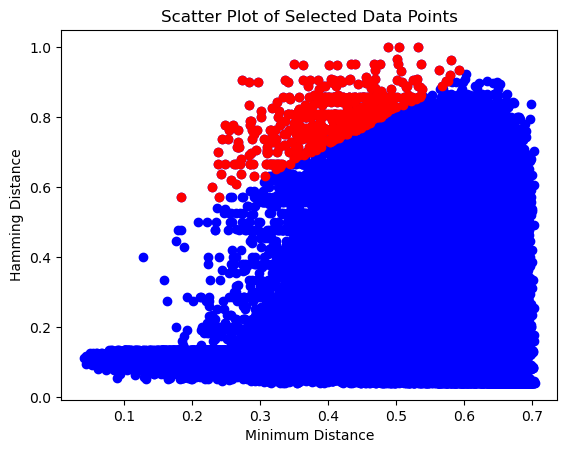

In [4]:
from matplotlib import pyplot as plt 
import numpy as np

# Calculate the distance from the diagonal (0.5, 0.5)
diagonal_distances = {}
for x, y,key1,key2 in zip(fRNAprob1.values(), fRNAprob2.values(), fRNAprob1.keys(), fRNAprob2.keys()):
    if key1 == key2:
        distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)
        diagonal_distances[key1] = distance

# Normalize the Hamming distances and diagonal distances
#max_hamming = max(fRNAhammingdistance.values())
#min_diagonal_distance = min(diagonal_distances.values())

#normalized_hamming = {name: hamming / max_hamming for name, hamming in fRNAhammingdistance.items()}
#normalized_diagonal_distance = {name: distance / min_diagonal_distance for name, distance in diagonal_distances.items()}

#Calculate the combined score (maximize Hamming distance and minimize diagonal distance)
scores = {}
for name in fRNAhammingdistance.keys(): 
    scores[name] = fRNAhammingdistance[name] - diagonal_distances[name] 
# Remove entries from scores where the sequence of dots is in fRNAfolds
filtered_scores = {key: value for key, value in scores.items() if '.' * len(key[1]) not in fRNAfolds[key]}

# Select the data points with the highest scores
selected_data = sorted(filtered_scores.items(), key=lambda item: item[1], reverse=True)

# Extract the Hamming values and their corresponding minimum distances
selected_hamming_values = [fRNAhammingdistance[name] for name, score in selected_data]
selected_min_distances = [diagonal_distances[name] for name, score in selected_data]
selected_names = [name[0] for name, score in selected_data]
selected_sequences = [name[1] for name, score in selected_data]

# Create a scatter plot
plt.scatter(selected_min_distances, selected_hamming_values, c='blue', marker='o')
plt.scatter(selected_min_distances[0:500], selected_hamming_values[0:500], c='red', marker='o')

# Add labels and title
plt.ylabel('Hamming Distance')
plt.xlabel('Minimum Distance')
plt.title('Scatter Plot of Selected Data Points')

# Show the plot
plt.show()

In [102]:
selected_data

[(('FR413689||Fly small RNA', 'AATCATGGTGCATGATGGCAC'), 0.6313754955053325),
 (('FR467115||Fly small RNA', 'GTTTCAACCTGGAGCGCAGG'), 0.6167559092183756),
 (('FR481095||Fly small RNA', 'TCGAAGTGGTTCGATTCCAC'), 0.6026128571148859),
 (('FR502527||Fly small RNA', 'TTGCCTGTTCGGCGAGGACGG'), 0.601743013802743),
 (('FR478375||Fly small RNA', 'TCAGGAGTTACTGTAACTT'), 0.583564379067137),
 (('FR450079||Fly small RNA', 'CTTTGGAGAAACTGAAGTTTC'), 0.5681520892325926),
 (('FR477986||Fly small RNA', 'TCACTGGGCAAAGTGTGTCT'), 0.5589642648147188),
 (('FR466299||Fly small RNA', 'GTTCGAACCCGGGCGGGA'), 0.5487616122090702),
 (('FR496963||Fly small RNA', 'TTAGCTTCAGGAGTTACTG'), 0.5455481534054067),
 (('FR472584||Fly small RNA', 'TAGAGTGGGATCTCTGGATCT'), 0.5418769723222319),
 (('FR440783||Fly small RNA', 'CGAGGAAGTGCTCCACTTT'), 0.534592051776477),
 (('FR241456||Putative conserved noncoding region (EvoFold)',
   'ATCTGTCTTCGGATGAAGAAT'),
  0.5312998857231882),
 (('FR454945||Fly small RNA', 'GATGGTCTCATCGACGGT'), 0

In [73]:
fRNAfolds[('FR000005|DQ755813|Piwi-interacting RNA (piRNA)',
  'AGTGCTAATAAGGTAAACAACTCGATGTTC')]

['..((((.....))))((((......)))).', '..((((.....))))...............']

In [75]:
filtered_scores

{('FR000005|DQ755813|Piwi-interacting RNA (piRNA)',
  'AGTGCTAATAAGGTAAACAACTCGATGTTC'): -15.038952404789432,
 ('FR000009||Putative conserved noncoding region (EvoFold)',
  'ATGAACTTGTTGTAGTTCTCAT'): -10.554815313922404,
 ('FR000010|DQ579278|Piwi-interacting RNA (piRNA)',
  'TGAATTCATGCAAATGCTAAAATGGTAGGC'): -15.292150357207888,
 ('FR000011|DQ605297,DQ765471|Piwi-interacting RNA (piRNA)',
  'TCGCCACTTGATACTCTATGACAATGGC'): -13.65577011061051,
 ('FR000014|DQ753912|Piwi-interacting RNA (piRNA)',
  'TGTGCAAACCTCGGGGTGGGGT'): -8.9413118435603,
 ('FR000015|DQ600988|Piwi-interacting RNA (piRNA)',
  'TAGAGGATTCTATGGCAGGACCAGAAC'): -12.324617927262205,
 ('FR000018|DQ568736|Piwi-interacting RNA (piRNA)',
  'TATTTGGAGAAGATGCCATCGTGTTTTATG'): -14.07761554726813,
 ('FR000020||Putative conserved noncoding region (EvoFold)',
  'ATTGCAGTTGCTGCTTTGTACAGAGGTTACTGCAAT'): -14.543177192069523,
 ('FR000022|DQ726353|Piwi-interacting RNA (piRNA)',
  'TACTTGTTCCAACACCATCTGATGGTCAAT'): -12.975600351787518,
 ('

In [72]:
filtered_scores

{('FR000005|DQ755813|Piwi-interacting RNA (piRNA)',
  'AGTGCTAATAAGGTAAACAACTCGATGTTC'): -0.3651936230160498,
 ('FR000009||Putative conserved noncoding region (EvoFold)',
  'ATGAACTTGTTGTAGTTCTCAT'): -0.3485772490367298,
 ('FR000010|DQ579278|Piwi-interacting RNA (piRNA)',
  'TGAATTCATGCAAATGCTAAAATGGTAGGC'): -0.5034753150263006,
 ('FR000011|DQ605297,DQ765471|Piwi-interacting RNA (piRNA)',
  'TCGCCACTTGATACTCTATGACAATGGC'): -0.49526995251033956,
 ('FR000014|DQ753912|Piwi-interacting RNA (piRNA)',
  'TGTGCAAACCTCGGGGTGGGGT'): -0.2819671520894995,
 ('FR000015|DQ600988|Piwi-interacting RNA (piRNA)',
  'TAGAGGATTCTATGGCAGGACCAGAAC'): 0.16585684880751939,
 ('FR000018|DQ568736|Piwi-interacting RNA (piRNA)',
  'TATTTGGAGAAGATGCCATCGTGTTTTATG'): -0.3894213264786969,
 ('FR000020||Putative conserved noncoding region (EvoFold)',
  'ATTGCAGTTGCTGCTTTGTACAGAGGTTACTGCAAT'): -0.5471224191052486,
 ('FR000022|DQ726353|Piwi-interacting RNA (piRNA)',
  'TACTTGTTCCAACACCATCTGATGGTCAAT'): 0.0395598942551500

In [33]:
for hamming,distance,name in zip(fRNAhammingdistance.values(), distances.values(),distances.keys()):
    if hamming>0.89 and distance<0.3:
        print(name, len(name[1]), hamming, distance)

('FR413689||Fly small RNA', 'AATCATGGTGCATGATGGCAC') 21 0.9047619047619048 0.2733864092565723
('FR467115||Fly small RNA', 'GTTTCAACCTGGAGCGCAGG') 20 0.9 0.2832440907816243
('FR481095||Fly small RNA', 'TCGAAGTGGTTCGATTCCAC') 20 0.9 0.29738714288511414


In [52]:
mindistancehamming = defaultdict(float)
mindistancehamming = defaultdict(lambda: (1.0, ''))

for hamming,distance,name in zip(fRNAhammingdistance.values(), distances.values(),distances.keys()):
    if distance < mindistancehamming[hamming][0]:
        mindistancehamming[hamming] = (distance,name)


In [2]:
import pickle
with open('../data/site_scanning_probs_pval_0.pkl', 'rb') as f:
    site_scanning_probs_pval_0 = pickle.load(f)

In [4]:
site_scanning_probs_pval_0['probs1']

[0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297645429,
 0.3588704592469527,
 0.3416623297